In [1]:
import numpy as pd
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from pyearth import Earth

In [2]:
cowpea = pd.read_excel('../data/prepared.xlsx', sheet_name='Cowpea')    ; cowpea['crop']   = 'cowpea'
maize = pd.read_excel('../data/prepared.xlsx', sheet_name='Maize')      ; maize['crop']    = 'maize'
rice = pd.read_excel('../data/prepared.xlsx', sheet_name='Rice')        ; rice['crop']     = 'rice'
chickpea = pd.read_excel('../data/prepared.xlsx', sheet_name='Chickpea'); chickpea['crop'] = 'chickpea'
mustard = pd.read_excel('../data/prepared.xlsx', sheet_name='Mustard')  ; mustard['crop']  = 'mustard'

In [3]:
# data = pd.concat([cowpea, rice, maize, chickpea, mustard], axis=0).reset_index(drop=True)
data = pd.concat([cowpea, rice, maize, chickpea], axis=0).reset_index(drop=True)

In [4]:
# Remove outliers
data = data[data['GSR']<=1000]

In [5]:
data.loc[:, 'Time'] = data.loc[:, 'Time'].apply(lambda x: x.hour)
data.loc[:, 'timesin'] = np.sin(data.loc[:, 'Time'] * (2 * np.pi) / 12)
data.loc[:, 'timecos'] = np.cos(data.loc[:, 'Time'] * (2 * np.pi) / 12)

In [6]:
df = pd.get_dummies(data[['crop']])
data = pd.concat([df, data], axis=1)

In [7]:
scalerx = StandardScaler()
scalery = StandardScaler()
data[['GSR','CT',]] = scalerx.fit_transform(data[['GSR','CT']])
data[['Rn']] = scalery.fit_transform(data[['Rn']])

In [8]:
feature_cols = [c for c in data.columns if c not in ['ST_5cm','ST_10cm','ST_15cm','Date','Time','crop','Rn']]
X = data[feature_cols]
y = data['Rn']

In [33]:
#Fit an Earth model
model = Earth(max_degree=2)
model.fit(X,y)

Earth(max_degree=2)

In [34]:
#Print the model
print(model.trace())
print(model.summary())

Forward Pass
---------------------------------------------------------------
iter  parent  var  knot  mse       terms  gcv    rsq    grsq   
---------------------------------------------------------------
0     -       -    -     1.000000  1      1.012  0.000  0.000  
1     0       4    110   0.452183  3      0.485  0.548  0.521  
2     0       7    -1    0.393399  4      0.435  0.607  0.570  
3     0       5    102   0.339600  6      0.399  0.660  0.606  
4     1       2    -1    0.268291  7      0.325  0.732  0.679  
5     3       5    159   0.252305  9      0.326  0.748  0.678  
6     4       4    4     0.210984  11     0.291  0.789  0.712  
7     5       6    -1    0.198046  12     0.283  0.802  0.721  
8     0       1    -1    0.186465  13     0.275  0.814  0.728  
9     12      6    -1    0.178504  14     0.273  0.821  0.730  
10    3       5    1     0.173621  16     0.285  0.826  0.718  
11    5       2    -1    0.167672  17     0.286  0.832  0.717  
12    2       2    -1    0.

In [35]:
X.columns

Index(['crop_chickpea', 'crop_cowpea', 'crop_maize', 'crop_rice', 'GSR', 'CT',
       'timesin', 'timecos'],
      dtype='object')

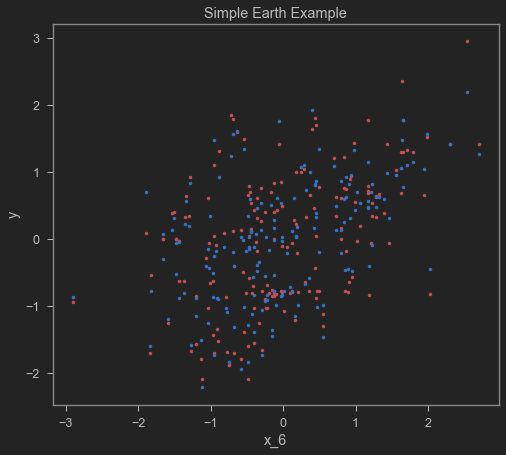

In [36]:
#Plot the model
y_hat = model.predict(X)
plt.figure()
plt.plot(X.iloc[:,5],y,'r.')
plt.plot(X.iloc[:,5],y_hat,'b.')
plt.xlabel('x_6')
plt.ylabel('y')
plt.title('Simple Earth Example')
plt.show()

In [37]:
kfold = KFold(n_splits=5)

In [38]:
all_stacked_mses = []
all_stacked_rmses = []
for (t_, v_) in kfold.split(X, y):
    model.fit(X.iloc[t_], y.iloc[t_])
    y_pred = scalery.inverse_transform(model.predict(X.iloc[v_][feature_cols]).reshape(-1,1))
    y_true = scalery.inverse_transform(y.iloc[v_].values.reshape(-1,1))
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    all_stacked_mses.append(mse)
    all_stacked_rmses.append(rmse)
#     print("Stacked estimator MSE:", mse)
#     print("Stacked estimator RMSE:", rmse)
#     print("\n")

print("Stacked estimator mean MSE:", np.mean(all_stacked_mses))
print("Stacked estimator mean RMSE:", np.mean(all_stacked_rmses))

Stacked estimator mean MSE: 8483.689215211429
Stacked estimator mean RMSE: 87.6553965913511
